In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import json

import os
import sys

In [2]:
import firebase_admin
from firebase_admin import credentials, storage

cred = credentials.Certificate('./b-sc-402909-firebase-adminsdk-yuf0e-000953c2f9.json')

if not firebase_admin._apps:
    firebase_admin.initialize_app(cred, {'storageBucket': 'b-sc-402909.appspot.com'})

bucket = storage.bucket()

folder_path = 'mousemovements/'

os.makedirs(folder_path, exist_ok=True)

blobs = bucket.list_blobs(prefix=folder_path)

for blob in blobs:
    print(f"Processing {blob.name}")
    if blob.name != folder_path:
        # Create the folder if it does not exist
        os.makedirs(os.path.dirname(blob.name), exist_ok=True)

        # Construct the local file path by replacing the folder path in the blob name
        local_file_path = os.path.join(folder_path, blob.name.replace(folder_path, ''))

        # Check if the file already exists
        if os.path.exists(local_file_path):
            print(f"File {local_file_path} already exists")
            continue

        # Download the file
        blob.download_to_filename(local_file_path)
        print(f"Downloaded {blob.name} to {local_file_path}")

Processing mousemovements/
Processing mousemovements/A/3/mousemovements0.json
Downloaded mousemovements/A/3/mousemovements0.json to mousemovements/A/3/mousemovements0.json


In [3]:
IMG_DIR = './images'

# Load images
imgs = {}
img_paths = {}

groups = ['A', 'B']

for group in groups:
    imgs[group] = {}
    img_paths[group] = {}

    for im in sorted(os.listdir(IMG_DIR + '/' + group + '/')):
        if im.endswith('.jpg'):
            img_path = IMG_DIR + '/' + group + '/' + im
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            imgs[group][im] = img
            img_paths[group][im] = img_path

In [4]:
HOME_DIR = './mousemovements'
movement_paths = {}

mouse_positions = {}
final_positions = {}
dimensions = {}

# For each image. find the corresponding directory from img_to_num and assign all mousemovements{i}.json to the corresponding image

for group in groups:
    mouse_positions[group] = {}
    final_positions[group] = {}
    dimensions[group] = {}
    movement_paths[group] = {}

    for img, img_dir in zip(imgs[group], list(img_paths[group].values())):
        movement_dir = img_dir.replace(IMG_DIR, HOME_DIR).replace('.jpg', '')
        movement_paths[group][img] = movement_dir

        mouse_positions[group][movement_dir] = {}
        final_positions[group][movement_dir] = {}
        dimensions[group][movement_dir] = {}

        # Check if it exists
        if not os.path.exists(movement_dir):
            print(f"Directory {movement_dir} does not exist")
            continue

        # Load all the mouse movements
        for mouse_movement in os.listdir(movement_dir):
            if mouse_movement.endswith('.json'):
                with open(os.path.join(movement_dir, mouse_movement), 'r') as f:
                    data = json.load(f)
                    mouse_positions[group][movement_dir][mouse_movement] = data['mousePositions']
                    final_positions[group][movement_dir][mouse_movement] = data['finalPosition']
                    dimensions[group][movement_dir][mouse_movement] = data['imageDimensions']

Directory ./mousemovements/A/0 does not exist
Directory ./mousemovements/A/1 does not exist
Directory ./mousemovements/A/2 does not exist
Directory ./mousemovements/B/0 does not exist
Directory ./mousemovements/B/1 does not exist
Directory ./mousemovements/B/2 does not exist
Directory ./mousemovements/B/3 does not exist


In [5]:
movement_paths

{'A': {'0.jpg': './mousemovements/A/0',
  '1.jpg': './mousemovements/A/1',
  '2.jpg': './mousemovements/A/2',
  '3.jpg': './mousemovements/A/3'},
 'B': {'0.jpg': './mousemovements/B/0',
  '1.jpg': './mousemovements/B/1',
  '2.jpg': './mousemovements/B/2',
  '3.jpg': './mousemovements/B/3'}}

In [6]:
def add_circle_to_heatmap(heatmap, x, y, radius, intensity=1):
    y_min, y_max = max(0, int(y - radius)), min(heatmap.shape[0], int(y + radius))
    x_min, x_max = max(0, int(x - radius)), min(heatmap.shape[1], int(x + radius))

    for i in range(y_min, y_max):
        for j in range(x_min, x_max):
            distance = np.sqrt((i - y)**2 + (j - x)**2)
            if distance <= radius:
                heatmap[i, j] += intensity

In [7]:
mouse_positions_interpolated = {}

for group in groups:
    mouse_positions_interpolated[group] = {}
    
    for img, movement_dir in zip(imgs[group], list(movement_paths[group].values())):
        mouse_positions_interpolated[group][movement_dir] = {}

        for mouse_movement in mouse_positions[group][movement_dir]:
            mouse_positions_interpolated[group][movement_dir][mouse_movement] = []

            for i in range(len(mouse_positions[group][movement_dir][mouse_movement])):
                if i == 0:
                    mouse_positions_interpolated[group][movement_dir][mouse_movement].append(mouse_positions[group][movement_dir][mouse_movement][i])

                x0, y0 = mouse_positions[group][movement_dir][mouse_movement][i - 1]
                x1, y1 = mouse_positions[group][movement_dir][mouse_movement][i]

                x = np.linspace(x0, x1, num=10)
                y = np.linspace(y0, y1, num=10)

                for j in range(10):
                    mouse_positions_interpolated[group][movement_dir][mouse_movement].append((x[j], y[j]))

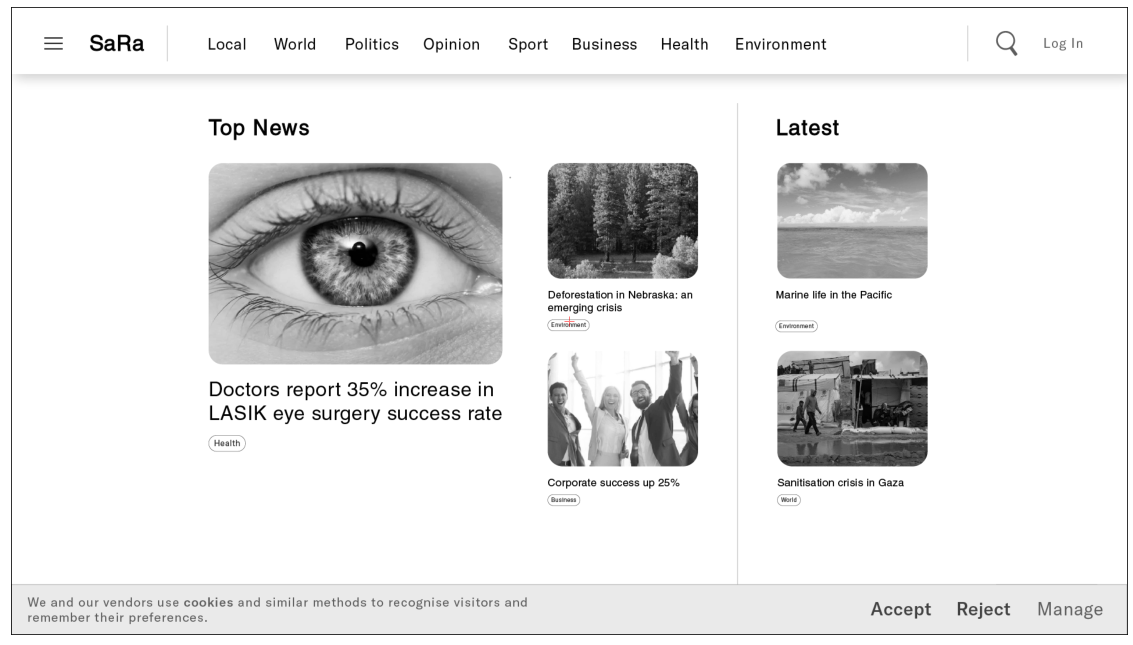

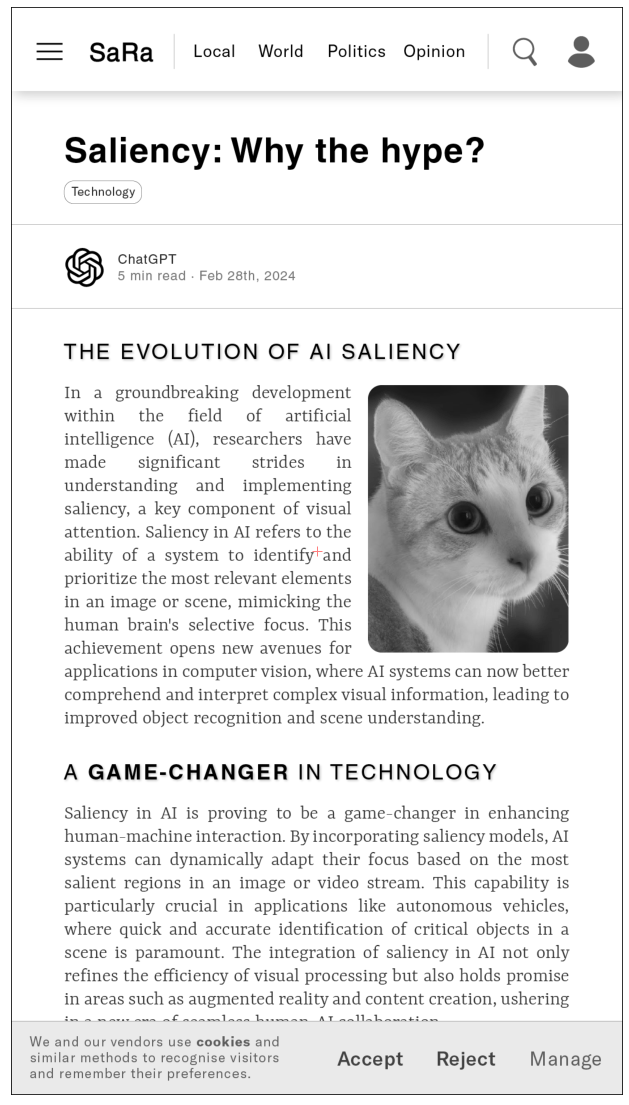

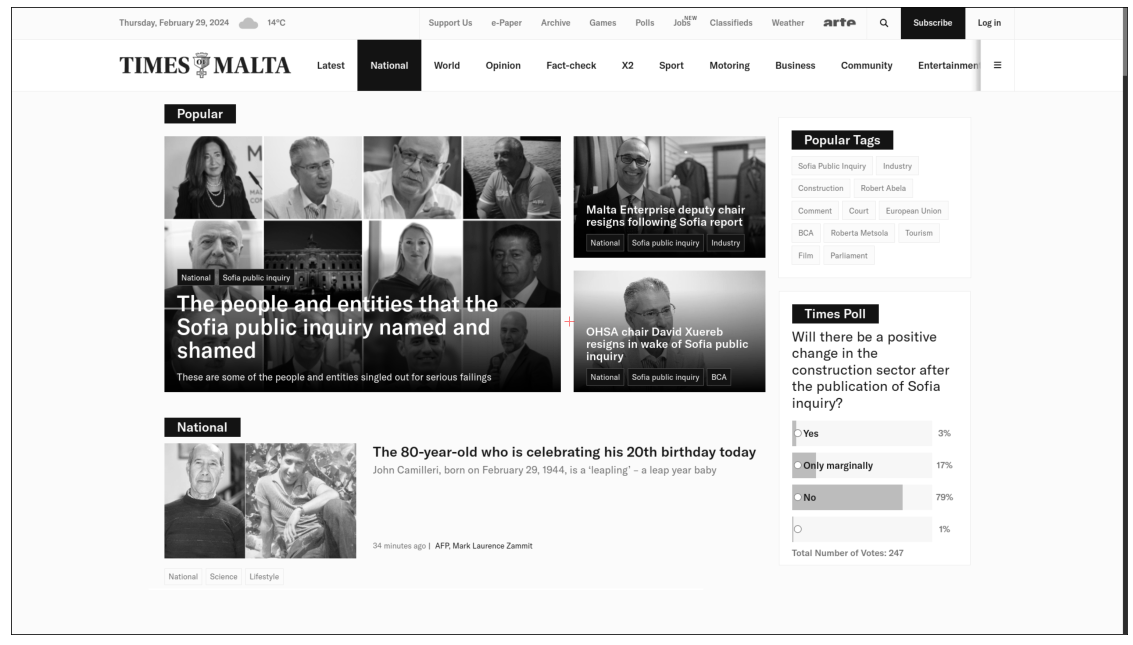

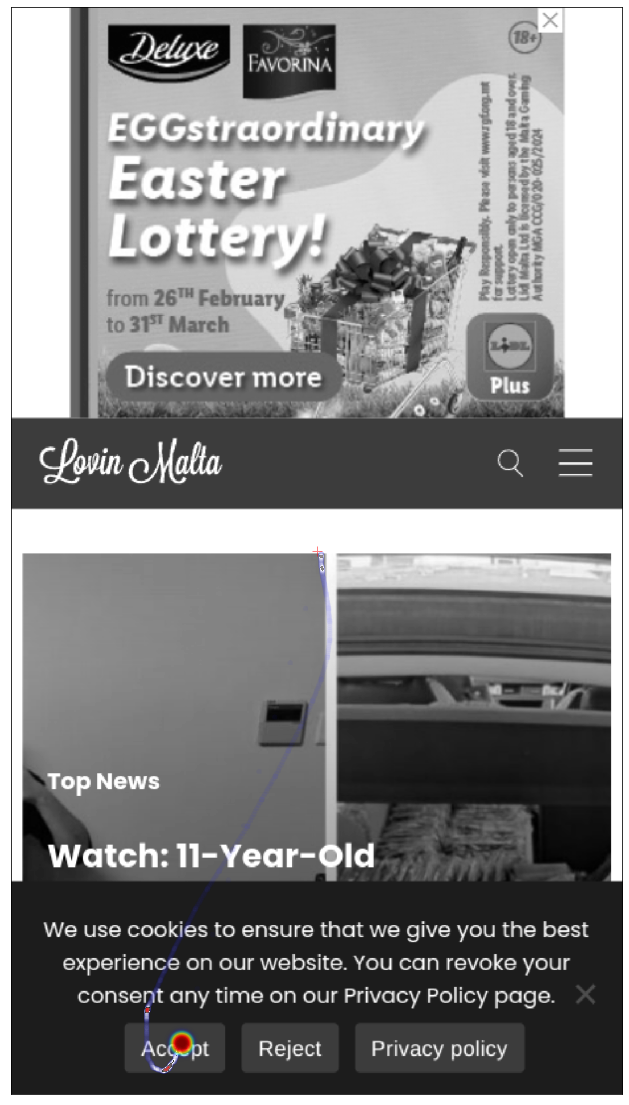

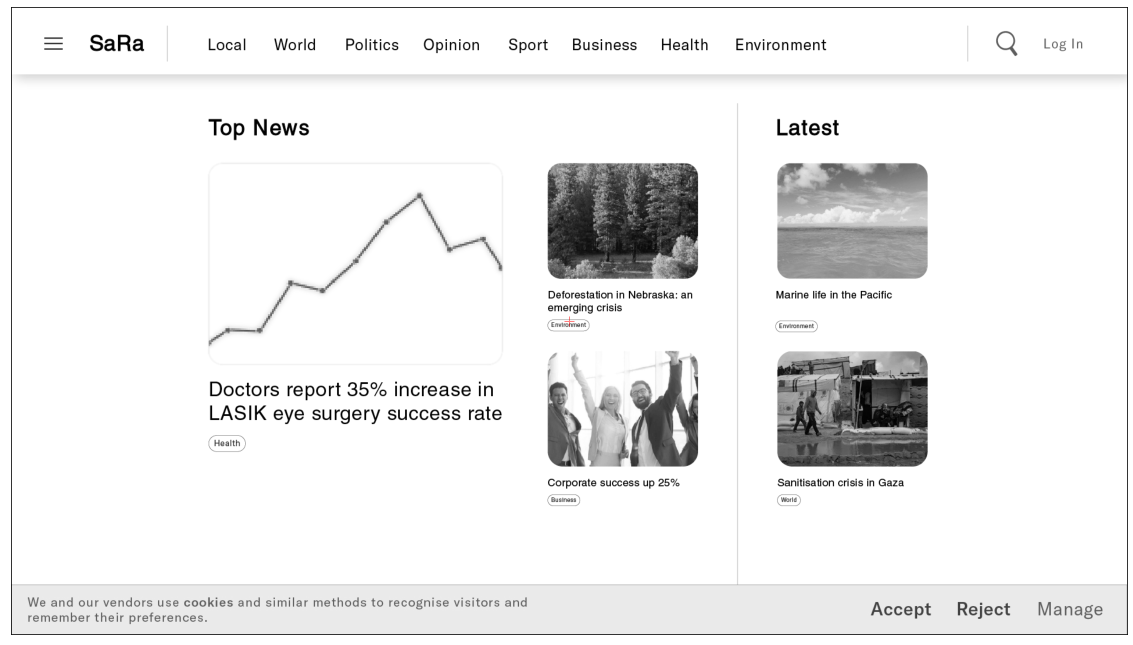

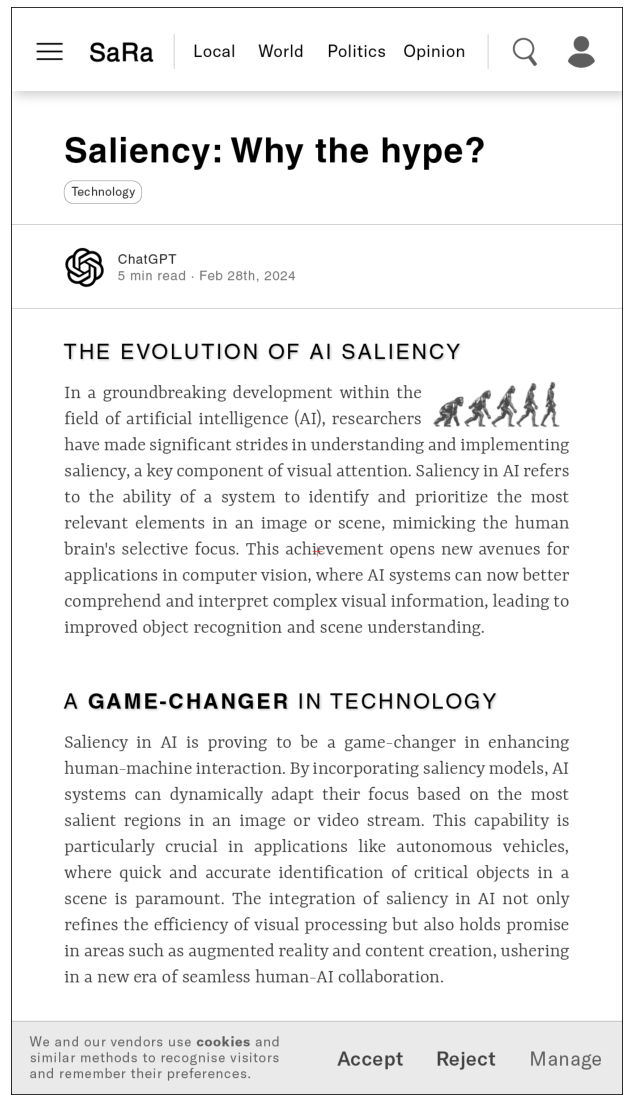

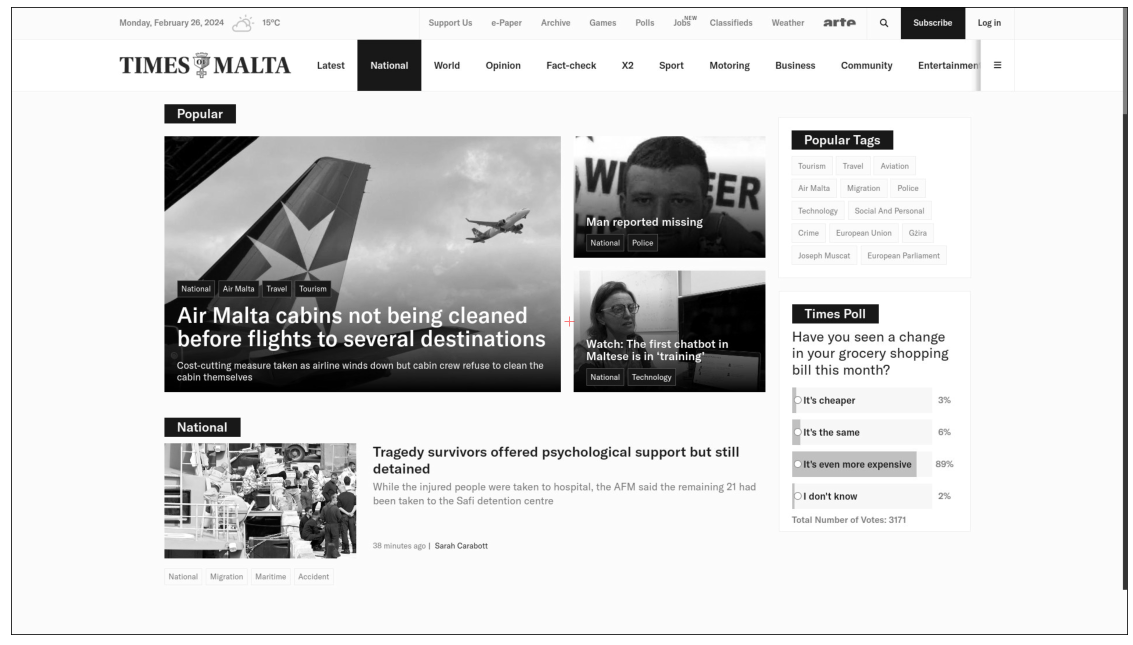

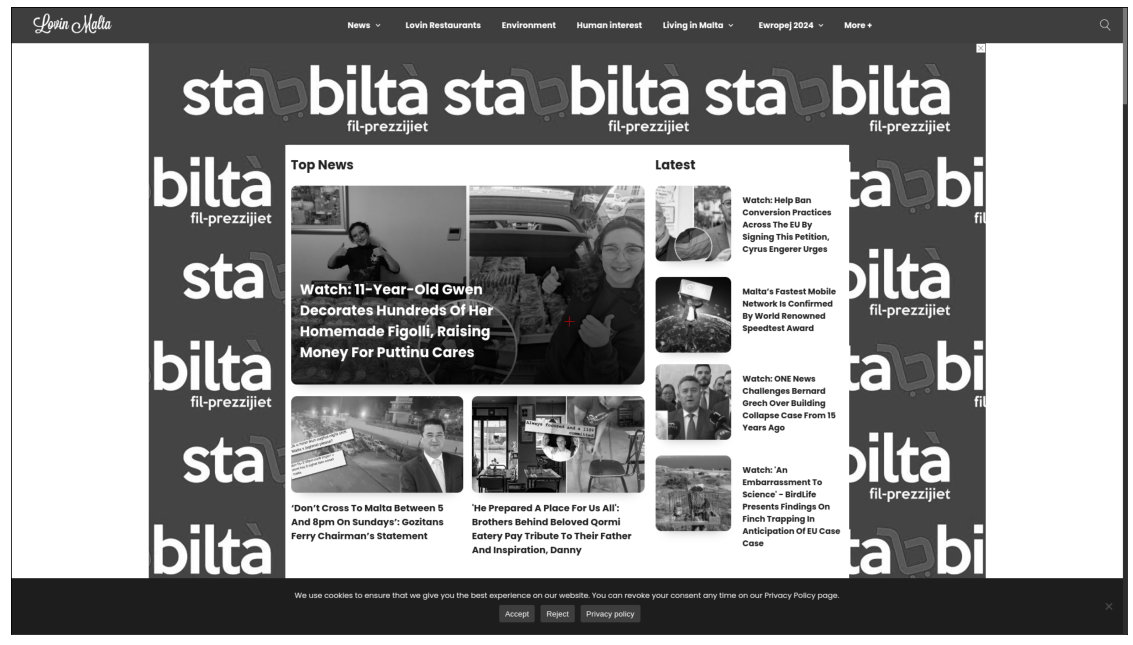

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from matplotlib.colors import LinearSegmentedColormap

ncolors = 256
color_array = plt.get_cmap('jet')(np.linspace(0, 1, 256))
gray_array = plt.get_cmap('bwr')(np.linspace(0, 1, 256))

# Make it so color_array is transparent at 0 and solid at 1
color_array[:,-1] = np.linspace(0,1.0,ncolors)
gray_array[:,-1] = np.linspace(0,1.0,ncolors)


map_object = LinearSegmentedColormap.from_list(name='coolwarm_alpha',colors=color_array)
plt.register_cmap(cmap=map_object)

map_object = LinearSegmentedColormap.from_list(name='gray_alpha',colors=gray_array)
plt.register_cmap(cmap=map_object)

# Assuming imgs, mouse_positions, and final_positions are defined

# Plot all images and mouse movements
for group in groups:
    for img, movement_dir in zip(imgs[group], list(movement_paths[group].values())):
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.imshow(cv2.cvtColor(imgs[group][img], cv2.COLOR_BGR2GRAY), cmap='gray')

        img_x = imgs[group][img].shape[1]
        img_y = imgs[group][img].shape[0]

        # print(img_x, img_y)

        # Add all final positions to a heatmap
        heatmap = np.zeros(imgs[group][img].shape[:2])
        movements = np.zeros(imgs[group][img].shape[:2])

        for mouse_movement in mouse_positions_interpolated[group][movement_dir]:
            mouse_positions_interpolated[group][movement_dir][mouse_movement] = np.array(mouse_positions_interpolated[group][movement_dir][mouse_movement])

            # Add points to the heatmap intermittently
            for i in range(0, len(mouse_positions_interpolated[group][movement_dir][mouse_movement]), 1):
                x, y  = mouse_positions_interpolated[group][movement_dir][mouse_movement][i]

                # Scale by the user's image dimensions such that they match the image
                # x = int(x * img_x / dimensions[img][mouse_movement]['width'])
                # y = int(y * img_y / dimensions[img][mouse_movement]['height'])

                # print(x, y)

                add_circle_to_heatmap(movements, x, y, radius=5, intensity=10)

        for mouse_movement in final_positions[group][movement_dir]:
            final_position = final_positions[group][movement_dir][mouse_movement].copy()

            # Scale by the user's image dimensions such that they match the image
            # final_position[0] = int(final_position[0] * img_x / dimensions[img][mouse_movement]['width'])
            # final_position[1] = int(final_position[1] * img_y / dimensions[img][mouse_movement]['height'])

            # Give the final position padding in a circle size of 5
            add_circle_to_heatmap(heatmap, final_position[0], final_position[1], radius=20, intensity=10)

        # Add a cross in the middle of the image
        ax.plot(img_x / 2, img_y / 2, 'r+', markersize=10, markeredgewidth=1, alpha=0.5)

        heatmap = cv2.GaussianBlur(heatmap, (31, 31), 5)

        ax.imshow(movements, cmap='gray_alpha', alpha=2)
        ax.imshow(heatmap, cmap='coolwarm_alpha', alpha=1)
        

        plt.xticks([]), plt.yticks([])
        plt.show()
